In [32]:

# 0) Imports & Config
import os, math, random
import numpy as np
import pandas as pd
from typing import Dict, Tuple, List
from collections import Counter

np.set_printoptions(suppress=True, linewidth=140)

M=3; J=53; T=40

PROB_EPS=1e-6; LOGIT_CLIP=7.0; STD_EPS=1e-12; SEED=0
rng=np.random.default_rng(SEED); random.seed(SEED)


c3_opt = {
    0: [1, 6, 10, 13, 15, 16, 19, 20, 22, 26, 28, 29, 34, 39, 40, 43, 45, 46, 47, 48, 51],
    1: [2, 4, 7, 8, 9, 11, 12, 14, 17, 18, 23, 24, 25, 27, 30, 33, 35, 38, 42, 44, 49, 52, 53],
    2: [3, 5, 21, 31, 32, 36, 37, 41, 50],
}


## Accuracy

In [33]:
import os, glob, json, re

def val_step0_acc_per_client(raw_dir="runs/mid_eval", pattern="client_*.raw"):
    paths = sorted(glob.glob(os.path.join(raw_dir, pattern)))
    if not paths:
        raise FileNotFoundError(f"No files matched: {os.path.join(raw_dir, pattern)}")

    result = {}
    for p in paths:
        # 파일명에서 client id 추출 (예: client_001.raw -> 1)
        m = re.search(r"client_(\d+)\.raw$", os.path.basename(p))
        file_client_id = int(m.group(1)) if m else None

        acc_at_step0 = None
        with open(p, "r", encoding="utf-8") as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                try:
                    rec = json.loads(line)
                except json.JSONDecodeError:
                    continue
                if rec.get("split") != "val":
                    continue
                if int(rec.get("step", -1)) != 0:
                    continue

                cid = int(rec.get("client", file_client_id))
                acc = rec.get("acc", None)
                if acc is not None:
                    acc_at_step0 = float(acc)
                    # 동일 파일에 여러 개 있을 일은 보통 없으니 첫 매치에서 종료
                    break

        # step 0 레코드가 존재할 때만 기록
        if acc_at_step0 is not None:
            result[cid] = acc_at_step0

    return result

# 사용 예
val_acc_dict_0 = val_step0_acc_per_client(raw_dir="./0_fedbis_oracle_u3_1.0/raw/mid_eval", pattern="client_*.raw")
val_acc_dict_1 = val_step0_acc_per_client(raw_dir="./1_fedbis_oracle_u3_1.0/raw/mid_eval", pattern="client_*.raw")
val_acc_dict_2 = val_step0_acc_per_client(raw_dir="./2_fedbis_oracle_u3_1.0/raw/mid_eval", pattern="client_*.raw")


val_acc_dict_g = val_step0_acc_per_client(raw_dir="./fedbis_1.0/raw/mid_eval", pattern="client_*.raw")



In [34]:
import os, glob, json, re

def test_step0_acc_per_client(raw_dir="runs/mid_eval", pattern="client_*.raw"):
    paths = sorted(glob.glob(os.path.join(raw_dir, pattern)))
    if not paths:
        raise FileNotFoundError(f"No files matched: {os.path.join(raw_dir, pattern)}")

    result = {}
    for p in paths:
        # 파일명에서 client id 추출 (예: client_001.raw -> 1)
        m = re.search(r"client_(\d+)\.raw$", os.path.basename(p))
        file_client_id = int(m.group(1)) if m else None

        acc_at_step0 = None
        with open(p, "r", encoding="utf-8") as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                try:
                    rec = json.loads(line)
                except json.JSONDecodeError:
                    continue
                if rec.get("split") != "test":
                    continue
                if int(rec.get("step", -1)) != 0:
                    continue

                cid = int(rec.get("client", file_client_id))
                acc = rec.get("acc", None)
                if acc is not None:
                    acc_at_step0 = float(acc)
                    # 동일 파일에 여러 개 있을 일은 보통 없으니 첫 매치에서 종료
                    break

        # step 0 레코드가 존재할 때만 기록
        if acc_at_step0 is not None:
            result[cid] = acc_at_step0

    return result

# 사용 예
test_acc_dict_0 = test_step0_acc_per_client(raw_dir="./0_fedbis_oracle_u3_1.0/raw/mid_eval", pattern="client_*.raw")
test_acc_dict_1 = test_step0_acc_per_client(raw_dir="./1_fedbis_oracle_u3_1.0/raw/mid_eval", pattern="client_*.raw")
test_acc_dict_2 = test_step0_acc_per_client(raw_dir="./2_fedbis_oracle_u3_1.0/raw/mid_eval", pattern="client_*.raw")



test_acc_dict_g = test_step0_acc_per_client(raw_dir="./fedbis_1.0/raw/mid_eval", pattern="client_*.raw")





In [35]:
accuracy_0=test_acc_dict_0
accuracy_1=test_acc_dict_1
accuracy_2=test_acc_dict_2

accuracy_g=test_acc_dict_g

In [36]:
# 클러스터별 accuracy dict 묶기
accuracy_by_cluster = {
    0: accuracy_0,
    1: accuracy_1,
    2: accuracy_2,
}

# 하드 클러스터링 최종 accuracy (client j → accuracy)
accuracy_hard: Dict[int, float] = {}

for k, clients in c3_opt.items():
    acc_k = accuracy_by_cluster[k]          # 해당 클러스터의 accuracy dict
    for j in clients:                       # 그 클러스터에 배정된 client들
        accuracy_hard[j] = acc_k[j]         # 그 client의 점수 선택


accuracy_hard = dict(sorted(accuracy_hard.items(), key=lambda x: x[0]))
print(accuracy_hard)

{1: 0.675, 2: 0.65, 3: 0.5, 4: 0.65, 5: 0.575, 6: 0.525, 7: 0.6, 8: 0.5, 9: 0.65, 10: 0.775, 11: 0.65, 12: 0.55, 13: 0.525, 14: 0.675, 15: 0.625, 16: 0.625, 17: 0.575, 18: 0.725, 19: 0.5, 20: 0.625, 21: 0.575, 22: 0.675, 23: 0.6, 24: 0.625, 25: 0.525, 26: 0.625, 27: 0.6, 28: 0.575, 29: 0.6, 30: 0.65, 31: 0.6, 32: 0.425, 33: 0.625, 34: 0.7, 35: 0.7, 36: 0.55, 37: 0.575, 38: 0.7, 39: 0.525, 40: 0.6, 41: 0.45, 42: 0.575, 43: 0.575, 44: 0.725, 45: 0.525, 46: 0.675, 47: 0.65, 48: 0.525, 49: 0.475, 50: 0.5, 51: 0.725, 52: 0.65, 53: 0.55}


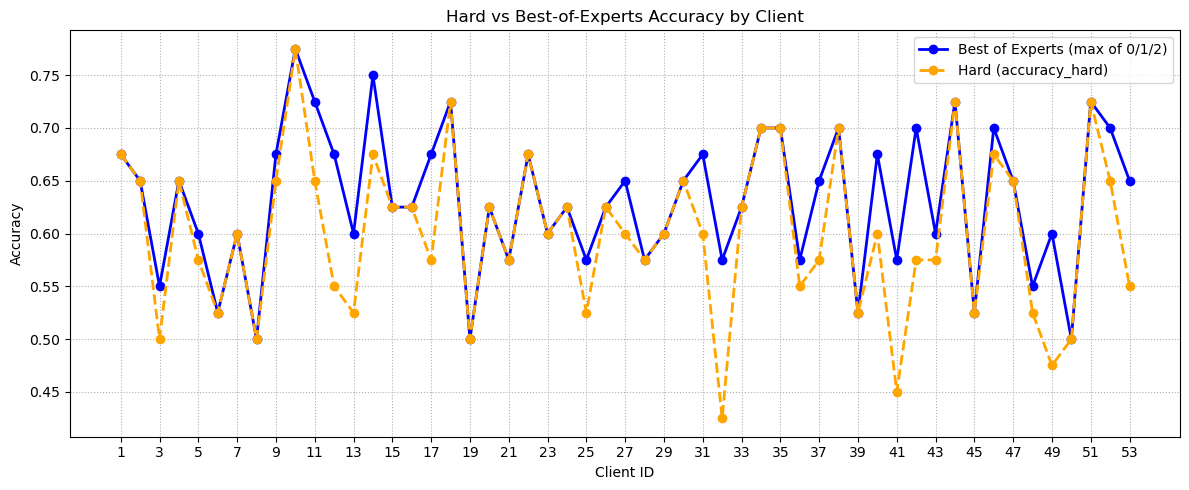

평균 Δ(hard→best): 0.0311,  Δ>0 비율: 43.4%


In [37]:
import matplotlib.pyplot as plt
import numpy as np

# 1) 키 정렬/검증
keys = list(range(1, 54))


# 2) 배열 변환
y0 = np.array([accuracy_0[k] for k in keys], dtype=float)
y1 = np.array([accuracy_1[k] for k in keys], dtype=float)
y2 = np.array([accuracy_2[k] for k in keys], dtype=float)
yh = np.array([accuracy_hard[k] for k in keys], dtype=float)

# 3) 전문가 Best 벡터 (클라이언트별 최대값)
ybest = np.maximum.reduce([y0, y1, y2])  # shape (53,)

# 4) 단일 차트: Hard vs Best-of-Experts
plt.figure(figsize=(12, 5))
plt.plot(keys, ybest, marker='o', linewidth=2, label='Best of Experts (max of 0/1/2)', color='blue')
plt.plot(keys, yh,    marker='o', linewidth=2, linestyle='--', label='Hard (accuracy_hard)', color='orange')

plt.xlabel('Client ID')
plt.ylabel('Accuracy')
plt.title('Hard vs Best-of-Experts Accuracy by Client')
plt.xticks(keys[::2])
plt.grid(True, linestyle=':')
plt.legend()
plt.tight_layout()
plt.show()

# (옵션) 하드→베스트 차이도 보고 싶으면:
delta = ybest - yh
print(f"평균 Δ(hard→best): {delta.mean():.4f},  Δ>0 비율: {(delta>0).mean()*100:.1f}%")


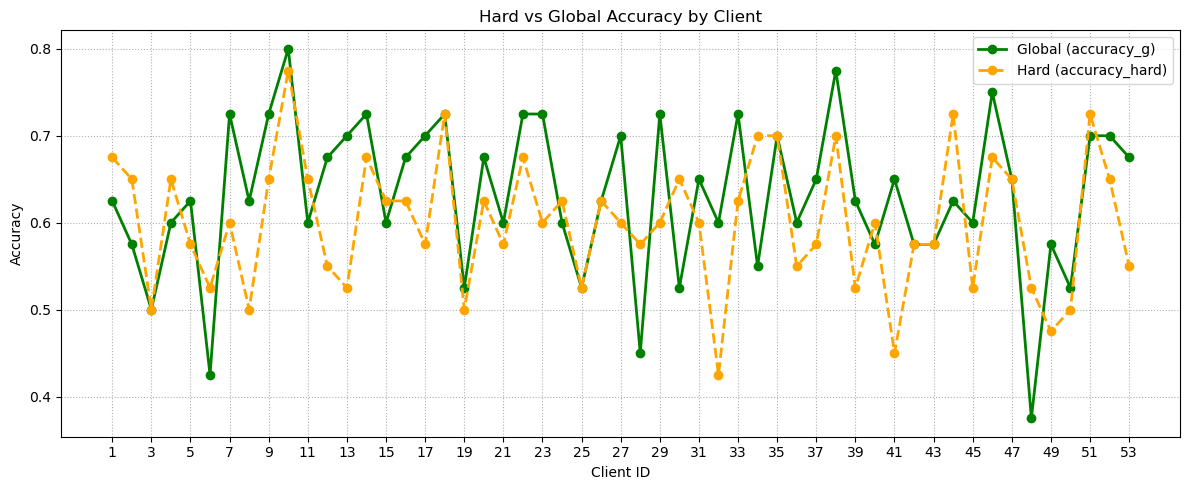

평균 Δ(hard→global): 0.0307,  Δ>0 비율: 58.5%


In [38]:
import matplotlib.pyplot as plt
import numpy as np

# 1) 키 정렬/검증
keys = list(range(1, 54))


# 2) 배열 변환
y0 = np.array([accuracy_0[k] for k in keys], dtype=float)
y1 = np.array([accuracy_1[k] for k in keys], dtype=float)
y2 = np.array([accuracy_2[k] for k in keys], dtype=float)


# 3) 전문가 Best 벡터 (클라이언트별 최대값)
ybest = np.maximum.reduce([y0, y1, y2])  # shape (53,)




yh = np.array([accuracy_hard[k] for k in keys], dtype=float)
yg = np.array([accuracy_g[k] for k in keys], dtype=float)

# 4) 단일 차트: Hard vs Best-of-Experts
plt.figure(figsize=(12, 5))
plt.plot(keys, yg, marker='o', linewidth=2, label='Global (accuracy_g)', color='green')
plt.plot(keys, yh,    marker='o', linewidth=2, linestyle='--', label='Hard (accuracy_hard)', color='orange')

plt.xlabel('Client ID')
plt.ylabel('Accuracy')
plt.title('Hard vs Global Accuracy by Client')
plt.xticks(keys[::2])
plt.grid(True, linestyle=':')
plt.legend()
plt.tight_layout()
plt.show()

# (옵션) 하드→베스트 차이도 보고 싶으면:
delta = yg - yh
print(f"평균 Δ(hard→global): {delta.mean():.4f},  Δ>0 비율: {(delta>0).mean()*100:.1f}%")


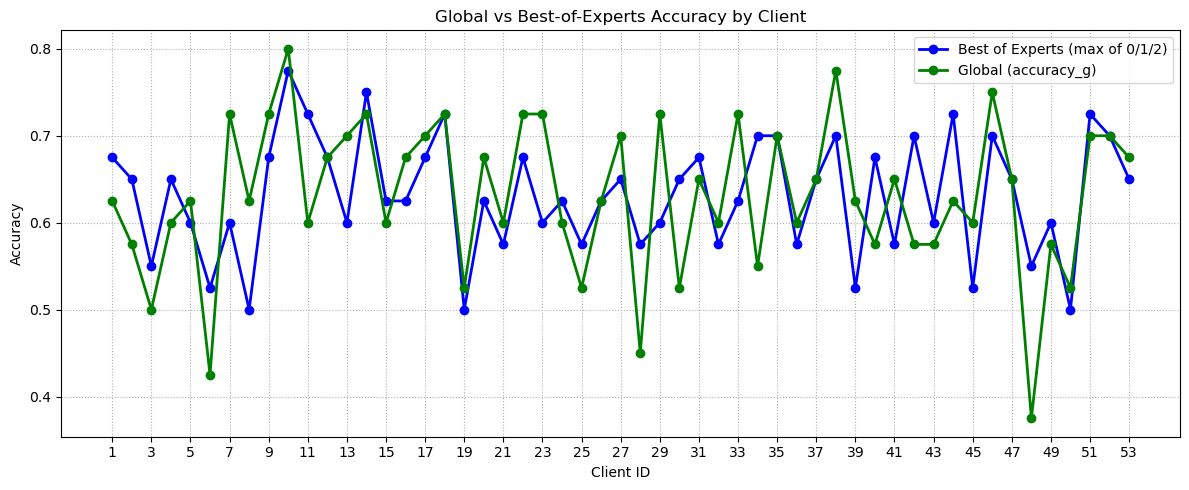

평균 Δ(global→best): 0.0005,  Δ>0 비율: 39.6%


In [39]:
import matplotlib.pyplot as plt
import numpy as np

# 1) 키 정렬/검증
keys = list(range(1, 54))


# 2) 배열 변환
y0 = np.array([accuracy_0[k] for k in keys], dtype=float)
y1 = np.array([accuracy_1[k] for k in keys], dtype=float)
y2 = np.array([accuracy_2[k] for k in keys], dtype=float)


# 3) 전문가 Best 벡터 (클라이언트별 최대값)
ybest = np.maximum.reduce([y0, y1, y2])  # shape (53,)




yh = np.array([accuracy_hard[k] for k in keys], dtype=float)
yg = np.array([accuracy_g[k] for k in keys], dtype=float)

# 4) 단일 차트: Hard vs Best-of-Experts
plt.figure(figsize=(12, 5))
plt.plot(keys, ybest, marker='o', linewidth=2, label='Best of Experts (max of 0/1/2)', color='blue')
plt.plot(keys, yg, marker='o', linewidth=2, label='Global (accuracy_g)', color='green')

plt.xlabel('Client ID')
plt.ylabel('Accuracy')
plt.title('Global vs Best-of-Experts Accuracy by Client')
plt.xticks(keys[::2])
plt.grid(True, linestyle=':')
plt.legend()
plt.tight_layout()
plt.show()

# (옵션) 하드→베스트 차이도 보고 싶으면:
delta = ybest - yg
print(f"평균 Δ(global→best): {delta.mean():.4f},  Δ>0 비율: {(delta>0).mean()*100:.1f}%")


In [40]:
accuracy_by_expert = {1: accuracy_0, 2: accuracy_1, 3: accuracy_2}


# 기본 파라미터
J = len(next(iter(accuracy_by_expert.values())))  # 클라이언트 수 추정
experts = sorted(accuracy_by_expert.keys())       # [1,2,3,4,5]


# 오름차순 키 보장 (1..J)
if set(accuracy_hard.keys()) != set(range(1, J+1)):
    # 정렬 및 누락 체크
    accuracy_hard = dict(sorted(accuracy_hard.items()))




# 테스트 정확도 행렬 A_test[u_idx, m-1]
A_test = np.zeros((len(experts), J), dtype=float)
for i, u in enumerate(experts):        # i = 0,1,2,3,4  / u = 1,2,3,4,5
    acc_u = accuracy_by_expert[u]
    A_test[i, :] = np.array([acc_u[m] for m in range(1, J+1)], dtype=float)

# ===================================================================
# 1-A) 전문가 Top-2 마진 (TEST 기준)
# ===================================================================
# top-1, top-2 expert index (0,1,2)와 margin 계산
top1 = np.argmax(A_test, axis=0)                    # shape (J,)
# 두 번째는 "자기 제외" argmax: trick으로 최댓값을 -inf로 바꿔서 다시 argmax
A_tmp = A_test.copy()
A_tmp[top1, np.arange(J)] = -np.inf
top2 = np.argmax(A_tmp, axis=0)                     # shape (J,)

gap_test = A_test[top1, np.arange(J)] - A_test[top2, np.arange(J)]  # shape (J,)
gap_mean = float(np.mean(gap_test))
gap_lt_5pct_ratio = float(np.mean(gap_test < 0.05))  # 5% 미만 비율

print("=== 1-A) Top-2 margin (TEST) ===")
print(f"평균 마진: {gap_mean:.4f}")
print(f"마진 < 5% 비율: {gap_lt_5pct_ratio*100:.1f}%")
# 히스토그램용 값: gap_test (벡터). 예: np.histogram(gap_test, bins=np.linspace(0, 0.5, 11))

# ===================================================================
# 1-B) 실제 하드배정 vs Best-of-3 (TEST)
# ===================================================================
# Best-of-5 정확도(각 m에 대해 최고 정확도)와 top1 expert
best_acc = A_test[top1, np.arange(J)]              # shape (J,)
# Hard 배정 정확도 벡터
hard_acc = np.array([accuracy_hard[m] for m in range(1, J+1)], dtype=float)

# (선택) 실제 하드 배정의 expert 인덱스 k(m)이 따로 있으면 사용하세요.
# 예) client2expert_hard = {m: 1|2|3, ...}
client2expert_hard = None  # 있으면 채우기

tol = 1e-12

if client2expert_hard is None:
    # 없으면 accuracy 값으로 추정 (동률/반올림 이슈 대비 허용오차 사용)
    k_idx = np.empty(J, dtype=int)  # 0,1,2 (전문가 인덱스)
    hard_match_all = []             # 하드값과 일치하는 모든 expert(동률)도 보존 (옵션)
    for m in range(1, J+1):
        hm = accuracy_hard[m]
        diffs = np.abs(A_test[:, m-1] - hm)
        cand = np.where(diffs <= tol)[0]
        if len(cand) == 0:
            # 완전 동일이 아니면, 가장 가까운 걸로 추정
            cand = np.array([int(np.argmin(diffs))])
        k_idx[m-1] = int(cand[0])
        hard_match_all.append([int(i+1) for i in cand])  # 1..3로 저장
else:
    # 1..5 → 0..4로 변환
    k_idx = np.array([client2expert_hard[m]-1 for m in range(1, J+1)], dtype=int)
    hard_match_all = [[int(client2expert_hard[m])] for m in range(1, J+1)]

hard_cluster_idx = k_idx + 1  # 1..5

# Δ_hard→best = best_acc - hard_acc
delta_hard_to_best = best_acc - hard_acc
delta_mean = float(np.mean(delta_hard_to_best))
delta_pos_ratio = float(np.mean(delta_hard_to_best > 0))  # 양수(개선 여지) 비율

print("\n=== 1-B) 하드배정 vs Best-of-3 (TEST) ===")
print(f"평균 Δ(hard→best): {delta_mean:.4f}")
print(f"Δ(hard→best) > 0 비율: {delta_pos_ratio*100:.1f}%")
# 분포/히스토그램: delta_hard_to_best 벡터 사용
# 예: np.histogram(delta_hard_to_best, bins=np.linspace(-0.2, 0.5, 15))

# ===== best_acc cluster index (동률 모두) =====
best_cluster_idx_all = []
for m in range(1, J+1):
    vmax = np.max(A_test[:, m-1])
    # tol 이내로 최고값과 같은 모든 expert(0..2) → (1..3)로 변환
    idxs = [i+1 for i, v in enumerate(A_test[:, m-1]) if abs(v - vmax) <= tol]
    best_cluster_idx_all.append(idxs)

# 보기 좋게 문자열로도 만들어둠(예: "1" 또는 "1,3")
best_cluster_idx_str = [",".join(map(str, idxs)) for idxs in best_cluster_idx_all]
hard_cluster_idx_str = [",".join(map(str, idxs)) for idxs in hard_match_all]  # (옵션) 하드도 동률 표시

# (옵션) 하드=베스트 동일 여부
hard_equals_best = [(hard_cluster_idx[i] in best_cluster_idx_all[i]) for i in range(J)]

# ===== 요약 테이블: 각 클라이언트별 top1, top2, margin, hard/best/Δ + 인덱스들 =====
summary = pd.DataFrame({
    "client": np.arange(1, J+1),
    "top1_expert(1-3)": top1 + 1,
    "top2_expert(1-3)": top2 + 1,
    "margin(top1-top2)": gap_test,
    "hard_acc": hard_acc,
    "best_acc": best_acc,
    "delta_hard_to_best": delta_hard_to_best,
    "hard_cluster_idx(1-3)": hard_cluster_idx,            # 단일 하드 인덱스
    "best_cluster_idx_all(1-3)": best_cluster_idx_all,    # 동률이면 여러 개
    "best_cluster_idx_str": best_cluster_idx_str,         # 보기 좋은 문자열
    # 아래 두 줄은 (옵션) 참고용
    # "hard_match_idx_all(1-3)": hard_match_all,          # 하드값과 일치하는 모든 expert
    # "hard_match_idx_str": hard_cluster_idx_str,         # 보기 좋은 문자열
    "hard_equals_best?": hard_equals_best,                # 하드가 베스트 집합에 포함?
})

print("\n요약(head):")
print(summary.head(53).to_string(index=False))


print(gap_test)


=== 1-A) Top-2 margin (TEST) ===
평균 마진: 0.0519
마진 < 5% 비율: 54.7%

=== 1-B) 하드배정 vs Best-of-3 (TEST) ===
평균 Δ(hard→best): 0.0311
Δ(hard→best) > 0 비율: 43.4%

요약(head):
 client  top1_expert(1-3)  top2_expert(1-3)  margin(top1-top2)  hard_acc  best_acc  delta_hard_to_best  hard_cluster_idx(1-3) best_cluster_idx_all(1-3) best_cluster_idx_str  hard_equals_best?
      1                 1                 2              0.050     0.675     0.675               0.000                      1                       [1]                    1               True
      2                 2                 1              0.125     0.650     0.650               0.000                      2                       [2]                    2               True
      3                 1                 2              0.025     0.500     0.550               0.050                      3                       [1]                    1              False
      4                 2                 1              0.100    

0.000: 11
0.025: 11
0.050: 13
0.075: 7
0.100: 4
0.125: 6
0.150: 1


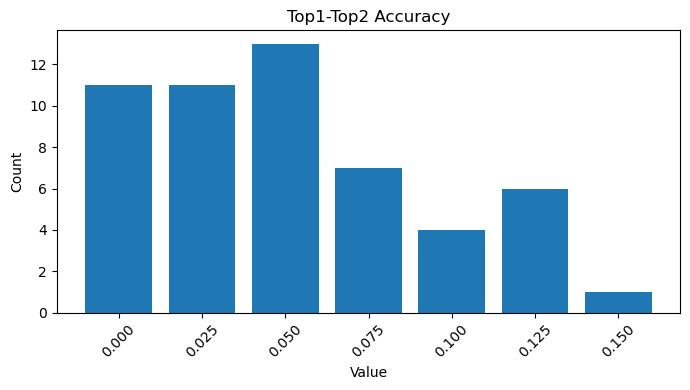

In [41]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# 데이터 (예시)
gap_test = np.array(gap_test)

step = 0.025

# 1) 값별(구간 아님) 개수 세기 — 정수 그리드로 변환해서 카운트
grid = np.rint(gap_test / step).astype(int)   # 0.025 단위 격자 인덱스
cnt = Counter(grid)

# 0부터 최대까지 누락도 0으로 채워 정렬된 결과 만들기
max_idx = int(np.rint(gap_test.max() / step))
ordered = [(i * step, cnt.get(i, 0)) for i in range(0, max_idx + 1)]

# 2) 원하는 형식으로 출력
for val, c in ordered:
    print(f"{val:.3f}: {c}")

# 3) 막대그래프(값 자체를 x축 카테고리로)
xs = [v for v, _ in ordered]
ys = [c for _, c in ordered]

plt.figure(figsize=(7,4))
plt.bar([str(f"{x:.3f}") for x in xs], ys)
plt.xlabel("Value")
plt.ylabel("Count")
plt.title(f"Top1-Top2 Accuracy")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


0.000: 30
0.025: 6
0.050: 4
0.075: 6
0.100: 2
0.125: 4
0.150: 1


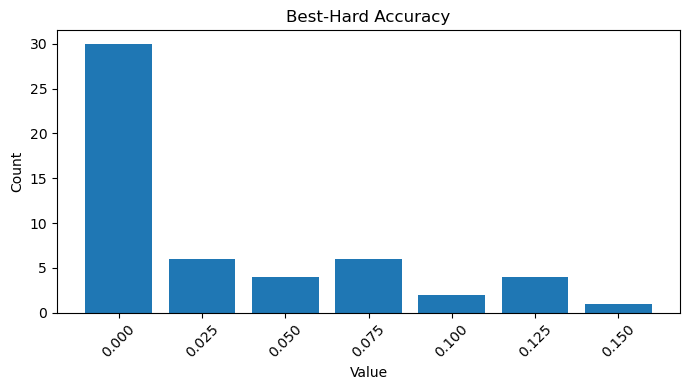

In [42]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# 데이터 (예시)
gap_test = np.array(delta_hard_to_best)

step = 0.025

# 1) 값별(구간 아님) 개수 세기 — 정수 그리드로 변환해서 카운트
grid = np.rint(gap_test / step).astype(int)   # 0.025 단위 격자 인덱스
cnt = Counter(grid)

# 0부터 최대까지 누락도 0으로 채워 정렬된 결과 만들기
max_idx = int(np.rint(gap_test.max() / step))
ordered = [(i * step, cnt.get(i, 0)) for i in range(0, max_idx + 1)]

# 2) 원하는 형식으로 출력
for val, c in ordered:
    print(f"{val:.3f}: {c}")

# 3) 막대그래프(값 자체를 x축 카테고리로)
xs = [v for v, _ in ordered]
ys = [c for _, c in ordered]

plt.figure(figsize=(7,4))
plt.bar([str(f"{x:.3f}") for x in xs], ys)
plt.xlabel("Value")
plt.ylabel("Count")
plt.title(f"Best-Hard Accuracy")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Winning Rate

In [43]:
def head_to_head_wins(dict_a, dict_b):
    """
    dict_a, dict_b: {client_id -> score} 형태
    반환:
      - A_wins/B_wins/ties
      - win_rate_overall: A_wins / 총키수 (무승부 포함)
      - win_rate_non_ties: A_wins / (A_wins + B_wins) (무승부 제외)
      - detail: {cid: {"A":a, "B":b, "result":"A/B/Tie", "diff": a-b}}
    """
    keys = sorted(set(dict_a) & set(dict_b))
    A_wins = B_wins = ties = 0
    detail = {}

    for k in keys:
        a = dict_a[k]
        b = dict_b[k]
        if a > b:
            A_wins += 1; res = "A"
        elif b > a:
            B_wins += 1; res = "B"
        else:
            ties += 1;  res = "Tie"
        detail[k] = {"A": a, "B": b, "result": res, "diff": a - b}

    total = len(keys)
    win_rate_overall   = A_wins / total if total else None
    non_ties = A_wins + B_wins
    win_rate_non_ties  = A_wins / non_ties if non_ties else None

    return {
        "A_wins": A_wins,
        "B_wins": B_wins,
        "ties": ties,
        "total": total,
        "win_rate_overall": win_rate_overall,
        "win_rate_non_ties": win_rate_non_ties,
        "detail": detail,
    }



### Hard vs Global

In [44]:
# 사용 예시
result = head_to_head_wins(accuracy_hard, accuracy_g)
print(result["A_wins"], result["B_wins"], result["ties"])


14 31 8


### Best hard vs Global

In [45]:
def to_client_dict(y, start_id=1):
    """
    y: 1D array-like (길이 = 클라이언트 수)
    반환: {start_id, start_id+1, ...} -> float 값
    """
    y = np.asarray(y).ravel()
    return {start_id + i: float(v) for i, v in enumerate(y)}

In [46]:
accuracy_hard_best = to_client_dict(ybest, start_id=1)

In [47]:
result = head_to_head_wins(accuracy_hard_best, accuracy_g)
print(result["A_wins"], result["B_wins"], result["ties"])

21 25 7


### Best hard vs Hard

In [48]:
result = head_to_head_wins(accuracy_hard_best, accuracy_hard)
print(result["A_wins"], result["B_wins"], result["ties"])

23 0 30


# Probs Ensemble

In [49]:
import os
import numpy as np
import pandas as pd
import os, glob, json, re


C = 53  # 클라이언트 수 (tgt_001~tgt_053)

# 경로 설정 (파일들이 저장된 디렉토리)
dir_path_g = "./fedbis_1.0/raw/probs"  # 파일이 업로드된 디렉토리 경로 

# probs, labels 초기화
probs_g = {i: [] for i in range(1, C+1)}  # probs[[i] -> 확률 값
labels = {j: [] for j in range(1, C+1)}  # labels[j] -> 라벨 값

# CSV 파일 로드 및 전처리

for j in range(1, C+1):  # 클라이언트 번호
    file_path = os.path.join(dir_path_g, f"tgt_{str(j).zfill(3)}.csv")
    
    # 각 파일이 존재하면 읽기
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        
        # 확률(p_A)과 라벨(label_num) 추출
        probs_g[j] = df['p_A'].values  # 모델 i의 클라이언트 j에 대한 p(A) 확률
        labels[j] = df['label_num'].values  # 클라이언트 j에 대한 라벨
        
    else:
        print(f"Warning: File {file_path} not found!")



# 경로 설정 (파일들이 저장된 디렉토리)
dir_path_0 = "./0_fedbis_oracle_u3_1.0/raw/probs"  # 파일이 업로드된 디렉토리 경로 

# probs, labels 초기화
probs_0 = {i: [] for i in range(1, C+1)}  # probs[[i] -> 확률 값


# CSV 파일 로드 및 전처리

for j in range(1, C+1):  # 클라이언트 번호
    file_path = os.path.join(dir_path_0, f"tgt_{str(j).zfill(3)}.csv")
    
    # 각 파일이 존재하면 읽기
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        
        # 확률(p_A)과 라벨(label_num) 추출
        probs_0[j] = df['p_A'].values  # 모델 i의 클라이언트 j에 대한 p(A) 확률
        
    else:
        print(f"Warning: File {file_path} not found!")


# 경로 설정 (파일들이 저장된 디렉토리)
dir_path_1 = "./1_fedbis_oracle_u3_1.0/raw/probs"  # 파일이 업로드된 디렉토리 경로 

# probs, labels 초기화
probs_1 = {i: [] for i in range(1, C+1)}  # probs[[i] -> 확률 값


# CSV 파일 로드 및 전처리

for j in range(1, C+1):  # 클라이언트 번호
    file_path = os.path.join(dir_path_1, f"tgt_{str(j).zfill(3)}.csv")
    
    # 각 파일이 존재하면 읽기
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        
        # 확률(p_A)과 라벨(label_num) 추출
        probs_1[j] = df['p_A'].values  # 모델 i의 클라이언트 j에 대한 p(A) 확률
        
    else:
        print(f"Warning: File {file_path} not found!")




# 경로 설정 (파일들이 저장된 디렉토리)
dir_path_2 = "./2_fedbis_oracle_u3_1.0/raw/probs"  # 파일이 업로드된 디렉토리 경로 

# probs, labels 초기화
probs_2 = {i: [] for i in range(1, C+1)}  # probs[[i] -> 확률 값


# CSV 파일 로드 및 전처리

for j in range(1, C+1):  # 클라이언트 번호
    file_path = os.path.join(dir_path_2, f"tgt_{str(j).zfill(3)}.csv")
    
    # 각 파일이 존재하면 읽기
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        
        # 확률(p_A)과 라벨(label_num) 추출
        probs_2[j] = df['p_A'].values  # 모델 i의 클라이언트 j에 대한 p(A) 확률
        
    else:
        print(f"Warning: File {file_path} not found!")



In [50]:
import numpy as np

def build_probs_ensemble_linear_by_valacc_multi(probs_list, val_acc_list):
    """
    probs_list    : [ {client_id -> np.ndarray}, ... ]  # 모델별 확률 딕셔너리들
    val_acc_list  : [ {client_id -> float}, ... ]       # 같은 순서의 val acc 딕셔너리들

    규칙:
      - 각 클라이언트 i에 대해 사용 가능한 (prob, acc) 쌍만 후보에 포함
        (prob 길이>0 이고 acc가 존재할 때)
      - 가중치 w_k = acc_k(i) / sum(acc_*(i)); 합이 0 이면 후보들 균등 가중
      - 후보들의 확률은 공통 최소 길이로 잘라 convex combination
    반환:
      {client_id -> np.ndarray}
    """
    assert len(probs_list) == len(val_acc_list), "probs_list와 val_acc_list 길이가 같아야 합니다."

    # 클라이언트 id 전체 집합
    all_clients = set()
    for p in probs_list:
        all_clients |= set(p.keys())
    all_clients = sorted(all_clients)

    out = {}
    for i in all_clients:
        candidates = []
        for probs_k, acc_k in zip(probs_list, val_acc_list):
            p = np.asarray(probs_k.get(i, []), dtype=float)
            if len(p) > 0 and (i in acc_k):
                a = float(acc_k[i])
                candidates.append((p, a))

        if not candidates:
            continue

        # 가중치 계산 (음수 방지, 합이 0이면 균등)
        accs = np.array([max(0.0, a) for _, a in candidates], dtype=float)
        s = accs.sum()
        if s <= 0:
            weights = np.full(len(candidates), 1.0/len(candidates), dtype=float)
        else:
            weights = accs / s

        # 공통 최소 길이로 자르고 가중합
        n = min(len(p) for p, _ in candidates)
        parts = [w * p[:n] for (p, _), w in zip(candidates, weights)]
        pe = np.sum(parts, axis=0)
        out[i] = np.clip(pe, 0.0, 1.0)

    return out





In [51]:
def build_probs_ensemble_linear_by_testacc_multi(probs_list, test_acc_list):
    """
    probs_list    : [ {client_id -> np.ndarray}, ... ]  # 모델별 확률 딕셔너리들
    test_acc_list : [ {client_id -> float}, ... ]       # 같은 순서의 test acc 딕셔너리들

    규칙:
      - 각 클라이언트 i에 대해 사용 가능한 (prob, acc) 쌍만 후보에 포함
        (prob 길이>0 이고 acc가 존재할 때)
      - 가중치 w_k = test_acc_k(i) / sum(test_acc_*(i)); 합이 0 이면 후보들 균등 가중
      - 후보들의 확률은 공통 최소 길이로 잘라 convex combination
    반환:
      {client_id -> np.ndarray}
    """
    assert len(probs_list) == len(test_acc_list), "probs_list와 test_acc_list 길이가 같아야 합니다."

    # 클라이언트 id 전체 집합
    all_clients = set()
    for p in probs_list:
        all_clients |= set(p.keys())
    all_clients = sorted(all_clients)

    out = {}
    for i in all_clients:
        candidates = []
        for probs_k, acc_k in zip(probs_list, test_acc_list):
            p = np.asarray(probs_k.get(i, []), dtype=float)
            if len(p) > 0 and (i in acc_k):
                a = float(acc_k[i])
                candidates.append((p, a))

        if not candidates:
            continue

        # 가중치 계산 (음수 방지, 합이 0이면 균등)
        accs = np.array([max(0.0, a) for _, a in candidates], dtype=float)
        s = accs.sum()
        if s <= 0:
            weights = np.full(len(candidates), 1.0 / len(candidates), dtype=float)
        else:
            weights = accs / s

        # 공통 최소 길이로 자르고 가중합
        n = min(len(p) for p, _ in candidates)
        parts = [w * p[:n] for (p, _), w in zip(candidates, weights)]
        pe = np.sum(parts, axis=0)
        out[i] = np.clip(pe, 0.0, 1.0)

    return out

In [52]:
def binarize_probs(probs_ensemble, thresh=0.5):
    """
    probs_ensemble: {client_id -> np.ndarray of probs}
    반환: {client_id -> np.ndarray of 0/1}
    """
    out = {}
    for cid, p in probs_ensemble.items():
        p = np.asarray(p, dtype=float)
        out[cid] = (p >= thresh).astype(int)
    return out

def per_client_match_ratio(bin_preds, labels, n_per_client=40):
    """
    bin_preds: {client_id -> np.ndarray of 0/1}
    labels   : {client_id -> np.ndarray of 0/1}
    각 클라이언트별로 앞의 n_per_client개에서
    일치 비율(=정확도)을 계산.
    """
    ratios = {}
    for cid in labels.keys():
        y = np.asarray(labels[cid], dtype=int)
        y = y[:n_per_client]  # 앞 40개
        p = np.asarray(bin_preds.get(cid, []), dtype=int)
        p = p[:len(y)]        # 길이 정렬(보호)
        if len(p) == 0 or len(y) == 0:
            continue
        # 필요시 p를 y 길이에 맞춰 잘라서 비교
        m = min(len(p), len(y))
        acc = (p[:m] == y[:m]).mean()
        ratios[cid] = float(acc)
    return ratios

def overall_mean_ratio(ratios):
    """클라이언트별 비율의 평균."""
    vals = list(ratios.values())
    return float(np.mean(vals)) if vals else None

### Val Ensemble

In [53]:
# 사용 예:
probs_ensemble_val = build_probs_ensemble_linear_by_valacc_multi(
        [probs_0, probs_1, probs_2],
        [val_acc_dict_0, val_acc_dict_1, val_acc_dict_2],
    )

In [54]:
# 1) 이진화
bin_preds_val = binarize_probs(probs_ensemble_val, thresh=0.5)

# 2) 클라이언트별 40개 기준 일치 비율 계산
accuracy_ensemble_val = per_client_match_ratio(bin_preds_val, labels, n_per_client=40)

# 3) 요약 출력 (예: 평균)
print("전체 평균 정확도(40개 기준):", overall_mean_ratio(accuracy_ensemble_val))

전체 평균 정확도(40개 기준): 0.5929245283018867


### Test Ensemble

In [55]:
# 사용 예:
probs_ensemble_test = build_probs_ensemble_linear_by_testacc_multi(
        [probs_0, probs_1, probs_2],
        [test_acc_dict_0, test_acc_dict_1, test_acc_dict_2],
    )

In [56]:
# 1) 이진화
bin_preds_test = binarize_probs(probs_ensemble_test, thresh=0.5)

# 2) 클라이언트별 40개 기준 일치 비율 계산
accuracy_ensemble_test = per_client_match_ratio(bin_preds_test, labels, n_per_client=40)

# 3) 요약 출력 (예: 평균)
print("전체 평균 정확도(40개 기준):", overall_mean_ratio(accuracy_ensemble_test))

전체 평균 정확도(40개 기준): 0.5966981132075473


In [57]:
print(accuracy_ensemble_test)

{1: 0.6, 2: 0.625, 3: 0.475, 4: 0.65, 5: 0.6, 6: 0.45, 7: 0.65, 8: 0.5, 9: 0.675, 10: 0.775, 11: 0.6, 12: 0.6, 13: 0.625, 14: 0.75, 15: 0.65, 16: 0.55, 17: 0.6, 18: 0.775, 19: 0.4, 20: 0.55, 21: 0.45, 22: 0.65, 23: 0.65, 24: 0.6, 25: 0.5, 26: 0.65, 27: 0.625, 28: 0.55, 29: 0.575, 30: 0.575, 31: 0.625, 32: 0.55, 33: 0.725, 34: 0.575, 35: 0.675, 36: 0.45, 37: 0.55, 38: 0.75, 39: 0.525, 40: 0.575, 41: 0.5, 42: 0.6, 43: 0.575, 44: 0.725, 45: 0.525, 46: 0.7, 47: 0.65, 48: 0.45, 49: 0.5, 50: 0.475, 51: 0.675, 52: 0.7, 53: 0.625}


# Select the model via val acc

In [58]:
def pick_test_by_best_val_multi(
    val_dicts, 
    test_dicts, 
    tie_strategy="first",         # 동률 처리: "first"(가장 앞 인덱스), "last"(가장 뒤 인덱스)
    key_mode="intersection"       # 키 집합: "intersection"(교집합), "union"(합집합)
):
    """
    val_dicts  : [ {client_id -> val_acc}, ... ]   # 길이 N
    test_dicts : [ {client_id -> test_acc}, ... ]  # 길이 N (val_dicts와 같은 순서/길이)

    반환:
      - out_test_by_best_val: {client_id -> 선택된 인덱스의 test_acc (없으면 None)}
      - chosen_index        : {client_id -> 선택된 인덱스(int)}
      - best_val            : {client_id -> 선택된 최대 val 값(float)}
    """
    assert len(val_dicts) == len(test_dicts) and len(val_dicts) > 0, "val_dicts와 test_dicts는 같은 길이의 비어있지 않은 리스트여야 합니다."

    # 키 집합 결정
    if key_mode == "intersection":
        keys = set(val_dicts[0].keys())
        for d in val_dicts[1:]:
            keys &= set(d.keys())
    elif key_mode == "union":
        keys = set()
        for d in val_dicts:
            keys |= set(d.keys())
    else:
        raise ValueError("key_mode는 'intersection' 또는 'union'만 허용합니다.")
    keys = sorted(keys)

    out_test_by_best_val = {}
    chosen_index = {}
    best_val = {}

    for k in keys:
        # 각 dict에서 k의 val 값을 모음 (없으면 -inf로 간주해 경쟁에서 제외)
        vals = [d.get(k, float("-inf")) for d in val_dicts]

        if tie_strategy == "first":
            idx = int(np.argmax(vals))              # 동률 시 가장 앞 인덱스
        elif tie_strategy == "last":
            # 뒤에서부터 최대 탐색
            rev_idx = int(np.argmax(vals[::-1]))
            idx = len(vals) - 1 - rev_idx
        else:
            raise ValueError("tie_strategy는 'first' 또는 'last'만 허용합니다.")

        chosen_index[k] = idx
        best_val[k] = vals[idx]

        # test 값: 해당 인덱스 test_dict에서 꺼내되 없으면 None
        test_val = test_dicts[idx].get(k, None)
        out_test_by_best_val[k] = test_val

    return out_test_by_best_val, chosen_index, best_val

In [59]:
accuracy_best_val, chosen_idx, best_val = pick_test_by_best_val_multi([val_acc_dict_0, val_acc_dict_1, val_acc_dict_2], [test_acc_dict_0, test_acc_dict_1, test_acc_dict_2])


print(best_test_by_key)
print(chosen_idx)
print(best_val)

{1: 0.675, 2: 0.525, 3: 0.5, 4: 0.5, 5: 0.6, 6: 0.525, 7: 0.6, 8: 0.45, 9: 0.675, 10: 0.725, 11: 0.5, 12: 0.675, 13: 0.525, 14: 0.75, 15: 0.475, 16: 0.625, 17: 0.675, 18: 0.7, 19: 0.5, 20: 0.625, 21: 0.45, 22: 0.675, 23: 0.575, 24: 0.625, 25: 0.525, 26: 0.625, 27: 0.65, 28: 0.475, 29: 0.6, 30: 0.6, 31: 0.675, 32: 0.575, 33: 0.625, 34: 0.7, 35: 0.7, 36: 0.425, 37: 0.65, 38: 0.65, 39: 0.525, 40: 0.6, 41: 0.575, 42: 0.7, 43: 0.575, 44: 0.575, 45: 0.525, 46: 0.675, 47: 0.65, 48: 0.525, 49: 0.425, 50: 0.425, 51: 0.725, 52: 0.7, 53: 0.65}
{1: 0, 2: 2, 3: 2, 4: 2, 5: 0, 6: 0, 7: 2, 8: 0, 9: 0, 10: 1, 11: 0, 12: 0, 13: 0, 14: 0, 15: 1, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 1, 25: 0, 26: 0, 27: 0, 28: 1, 29: 0, 30: 0, 31: 0, 32: 0, 33: 2, 34: 0, 35: 1, 36: 1, 37: 0, 38: 0, 39: 0, 40: 0, 41: 1, 42: 0, 43: 0, 44: 0, 45: 1, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0}
{1: 0.6232876712328768, 2: 0.7272727272727273, 3: 0.5277777777777778, 4: 0.5454545454545454, 5: 0.

# Summary

In [61]:
print("전체 평균 정확도(40개 기준), Global:", overall_mean_ratio(accuracy_g))

print("전체 평균 정확도(40개 기준), Hard:", overall_mean_ratio(accuracy_hard))
print("전체 평균 정확도(40개 기준), Hard Best:", overall_mean_ratio(accuracy_hard_best))

print("전체 평균 정확도(40개 기준), Ensemble Test:", overall_mean_ratio(accuracy_ensemble_test))
print("전체 평균 정확도(40개 기준), Ensemble Val:", overall_mean_ratio(accuracy_ensemble_val))

print("전체 평균 정확도(40개 기준), Hard Best val:", overall_mean_ratio(accuracy_best_val))

전체 평균 정확도(40개 기준), Global: 0.6311320754716981
전체 평균 정확도(40개 기준), Hard: 0.6004716981132077
전체 평균 정확도(40개 기준), Hard Best: 0.6316037735849057
전체 평균 정확도(40개 기준), Ensemble Test: 0.5966981132075473
전체 평균 정확도(40개 기준), Ensemble Val: 0.5929245283018867
전체 평균 정확도(40개 기준), Hard Best val: 0.593867924528302
